In [1]:
!pip install joblib


1. Aqui hemos creado los diferentes dataframes para poder trabajar con ellos y crear el modelo predictivo en el cual nos vamos a basar para despues crear nuestro estudio

In [2]:
import pandas as pd

# Cargar el dataframe
play_by_play_df = pd.read_csv('c:/Users/Casa/Documents/GitHub/ProjecyEuroleague/data cleaned/play2023clean.csv')

# # Limpiar datos (por ejemplo, eliminando filas con valores nulos o irrelevantes)
data_clean = play_by_play_df.dropna(subset=['team_id', 'player_id', 'points_a', 'points_b'])

# Verificar los datos
print(data_clean.head())

     game_play_id    game_id     game  round           phase season_code  \
2   E2023_001_006  E2023_001  RED-ASV      1  REGULAR SEASON       E2023   
3   E2023_001_007  E2023_001  RED-ASV      1  REGULAR SEASON       E2023   
5   E2023_001_010  E2023_001  RED-ASV      1  REGULAR SEASON       E2023   
6   E2023_001_011  E2023_001  RED-ASV      1  REGULAR SEASON       E2023   
10  E2023_001_018  E2023_001  RED-ASV      1  REGULAR SEASON       E2023   

   quarter  type  number_of_play team_id  ... play_type              player  \
2       q1     0               6     ASV  ...      2FGM  LAUVERGNE, JOFFREY   
3       q1     0               7     RED  ...      3FGM       LAZIC, BRANKO   
5       q1     0              10     ASV  ...      2FGM  LAUVERGNE, JOFFREY   
6       q1     0              11     RED  ...      3FGM    SIMONOVIC, MARKO   
10      q1     0              18     RED  ...      3FGM     NAPIER, SHABAZZ   

                                  team dorsal  minute  marker_time p

Aqui creamos una columna llamada Total points 

In [3]:
# Asegurarnos de que points_a y points_b no tienen valores nulos
data_clean['total_points'] = data_clean['points_a'].fillna(0) + data_clean['points_b'].fillna(0)

C:\Users\Casa\AppData\Local\Temp\ipykernel_17148\2985877394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['total_points'] = data_clean['points_a'].fillna(0) + data_clean['points_b'].fillna(0)


Convertimos el tiempo a otro formato para no tener problemas

In [4]:
# Convertir el tiempo de formato MM:SS a segundos
def time_to_seconds(marker_time):
    try:
        minutes, seconds = map(int, marker_time.split(':'))
        return minutes * 60 + seconds
    except:
        return 0  # Si el tiempo no es válido, lo tratamos como 0

data_clean['marker_time_seconds'] = data_clean['marker_time'].apply(time_to_seconds)

# Verificar la transformación
data_clean[['marker_time', 'marker_time_seconds']].head()


C:\Users\Casa\AppData\Local\Temp\ipykernel_17148\2831229772.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['marker_time_seconds'] = data_clean['marker_time'].apply(time_to_seconds)


,marker_time,marker_time_seconds
2,09:36,576
3,09:14,554
5,08:42,522
6,08:42,522
10,07:58,478


In [5]:
# show all columns 
pd.set_option('display.max_columns', None)

Aqui vamos añadiendo caracteristicas a nuestro dataframe

In [12]:
final_scores = data_clean.groupby('game_id').agg({
    'points_a': 'last',
    'points_b': 'last',
    'team_id': 'last',
    'team': 'last'
}).reset_index()

final_scores['winner'] = final_scores.apply(lambda row: row['team'] if row['points_a'] > row['points_b'] else 'Other Team', axis=1)

data_clean_winner = data_clean.merge(final_scores[['game_id', 'winner']], on='game_id', how='left')

data_clean_winner.head(5)

,game_play_id,game_id,game,round,phase,season_code,quarter,type,number_of_play,team_id,player_id,play_type,player,team,dorsal,minute,marker_time,points_a,points_b,comment,play_info,total_points,marker_time_seconds,winner_x,winner_y
0,E2023_001_006,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,6,ASV,P004194,2FGM,"LAUVERGNE, JOFFREY",LDLC ASVEL Villeurbanne,7.0,1,09:36,0.0,2.0,NaN,Two Pointer (1/1 - 2 pt),2.0,576,team_b,Crvena Zvezda Meridianbet Belgrade
1,E2023_001_007,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,7,RED,PLUO,3FGM,"LAZIC, BRANKO",Crvena Zvezda Meridianbet Belgrade,10.0,1,09:14,3.0,2.0,NaN,Three Pointer (1/1 - 3 pt),5.0,554,team_a,Crvena Zvezda Meridianbet Belgrade
2,E2023_001_010,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,10,ASV,P004194,2FGM,"LAUVERGNE, JOFFREY",LDLC ASVEL Villeurbanne,7.0,2,08:42,3.0,4.0,NaN,Two Pointer (2/2 - 4 pt),7.0,522,team_b,Crvena Zvezda Meridianbet Belgrade
3,E2023_001_011,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,11,RED,P012711,3FGM,"SIMONOVIC, MARKO",Crvena Zvezda Meridianbet Belgrade,11.0,2,08:42,6.0,4.0,NaN,Three Pointer (1/1 - 3 pt),10.0,522,team_a,Crvena Zvezda Meridianbet Belgrade
4,E2023_001_018,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,18,RED,P011224,3FGM,"NAPIER, SHABAZZ",Crvena Zvezda Meridianbet Belgrade,13.0,3,07:58,9.0,4.0,NaN,Three Pointer (1/1 - 3 pt),13.0,478,team_a,Crvena Zvezda Meridianbet Belgrade


Hemos creado dos columnas donde se suman los puntos de a y b para poder analizar nuestro dataframe

In [13]:
data_clean_winner['cumulative_points_a'] = data_clean_winner['points_a'].cumsum()
data_clean_winner['cumulative_points_b'] = data_clean_winner['points_b'].cumsum()

# Determinar el ganador en cada momento (acumulado)
data_clean_winner['winner_y'] = data_clean_winner.apply(lambda row: row['team'] if row['cumulative_points_a'] > row['cumulative_points_b'] else 'Other Team', axis=1)

print(data_clean_winner[['game_play_id', 'points_a', 'points_b', 'cumulative_points_a', 'cumulative_points_b', 'winner_y']])



        game_play_id  points_a  points_b  cumulative_points_a  \
0      E2023_001_006       0.0       2.0                  0.0   
1      E2023_001_007       3.0       2.0                  3.0   
2      E2023_001_010       3.0       4.0                  6.0   
3      E2023_001_011       6.0       4.0                 12.0   
4      E2023_001_018       9.0       4.0                 21.0   
...              ...       ...       ...                  ...   
28352  E2023_333_561      77.0      91.0            1239948.0   
28353  E2023_333_566      77.0      92.0            1240025.0   
28354  E2023_333_567      77.0      93.0            1240102.0   
28355  E2023_333_571      77.0      95.0            1240179.0   
28356  E2023_333_578      80.0      95.0            1240259.0   

       cumulative_points_b                            winner_y  
0                      2.0                          Other Team  
1                      4.0                          Other Team  
2                      8

In [19]:
data_clean_winner.head(5)

,game_play_id,game_id,game,round,phase,season_code,quarter,type,number_of_play,team_id,player_id,play_type,player,team,dorsal,minute,marker_time,points_a,points_b,comment,play_info,total_points,marker_time_seconds,winner_x,winner_y,cumulative_points_a,cumulative_points_b
0,E2023_001_006,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,6,ASV,P004194,2FGM,"LAUVERGNE, JOFFREY",LDLC ASVEL Villeurbanne,7.0,1,09:36,0.0,2.0,NaN,Two Pointer (1/1 - 2 pt),2.0,576,team_b,Other Team,0.0,2.0
1,E2023_001_007,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,7,RED,PLUO,3FGM,"LAZIC, BRANKO",Crvena Zvezda Meridianbet Belgrade,10.0,1,09:14,3.0,2.0,NaN,Three Pointer (1/1 - 3 pt),5.0,554,team_a,Other Team,3.0,4.0
2,E2023_001_010,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,10,ASV,P004194,2FGM,"LAUVERGNE, JOFFREY",LDLC ASVEL Villeurbanne,7.0,2,08:42,3.0,4.0,NaN,Two Pointer (2/2 - 4 pt),7.0,522,team_b,Other Team,6.0,8.0
3,E2023_001_011,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,11,RED,P012711,3FGM,"SIMONOVIC, MARKO",Crvena Zvezda Meridianbet Belgrade,11.0,2,08:42,6.0,4.0,NaN,Three Pointer (1/1 - 3 pt),10.0,522,team_a,Other Team,12.0,12.0
4,E2023_001_018,E2023_001,RED-ASV,1,REGULAR SEASON,E2023,q1,0,18,RED,P011224,3FGM,"NAPIER, SHABAZZ",Crvena Zvezda Meridianbet Belgrade,13.0,3,07:58,9.0,4.0,NaN,Three Pointer (1/1 - 3 pt),13.0,478,team_a,Crvena Zvezda Meridianbet Belgrade,21.0,16.0


In [6]:
# Puntos totales por equipo por partido
puntos_por_equipo = data_clean.groupby(['game_id', 'team_id'])['total_points'].sum().reset_index()

# Desempeño por cuarto
desempeno_por_cuarto = data_clean.groupby(['game_id', 'team_id', 'quarter'])['total_points'].sum().reset_index()


In [7]:
# Eliminar los datos donde el equipo sea "Panathinaikos AKTOR Athens"
data_clean = data_clean[data_clean['team'] != 'Panathinaikos AKTOR Athens']

# Verifica que se hayan eliminado correctamente
print(data_clean[data_clean['team'] == 'Panathinaikos AKTOR Athens'])


Empty DataFrame
Columns: [game_play_id, game_id, game, round, phase, season_code, quarter, type, number_of_play, team_id, player_id, play_type, player, team, dorsal, minute, marker_time, points_a, points_b, comment, play_info, total_points, marker_time_seconds, winner]
Index: []

[0 rows x 24 columns]


In [16]:
head_to_head_df = pd.read_csv('c:/Users/Casa/Documents/GitHub/ProjecyEuroleague/data cleaned/head_to_head_2023.csv')

In [17]:
# Unir con los datos de enfrentamientos directos (head_to_head_2023)
data_enriquecido = pd.merge(
    data_clean_winner, 
    head_to_head_df[['team_id_a', 'team_id_b', 'team_a_win', 'team_b_win', 'dominance']],
    left_on='team_id',
    right_on='team_id_a', 
    how='left'
)


In [40]:
data_enriquecido.to_csv('data_enriquecido.csv',index=False) 

In [58]:
data_enriquecido = data_enriquecido[data_enriquecido['team'] != 'Panathinaikos Athens']
data_enriquecido = data_enriquecido[data_enriquecido['team'] != 'Other Team']
# Verifica que se hayan eliminado correctamente
print(data_enriquecido[data_enriquecido['team'] == 'Panathinaikos Athens'])
print(data_enriquecido[data_enriquecido['team'] == 'Other Team'])

Empty DataFrame
Columns: [game_play_id, game_id, game, round, phase, season_code, quarter, type, number_of_play, team_id, player_id, play_type, player, team, dorsal, minute, marker_time, points_a, points_b, comment, play_info, total_points, marker_time_seconds, winner_x, winner_y, cumulative_points_a, cumulative_points_b, team_id_a, team_id_b, team_a_win, team_b_win, dominance, winner_y_encoded]
Index: []
Empty DataFrame
Columns: [game_play_id, game_id, game, round, phase, season_code, quarter, type, number_of_play, team_id, player_id, play_type, player, team, dorsal, minute, marker_time, points_a, points_b, comment, play_info, total_points, marker_time_seconds, winner_x, winner_y, cumulative_points_a, cumulative_points_b, team_id_a, team_id_b, team_a_win, team_b_win, dominance, winner_y_encoded]
Index: []


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Cargar los datos
df = pd.read_csv('c:/Users/Casa/Documents/GitHub/ProjecyEuroleague/data cleaned/data_enriquecido.csv')

# Verificar si la columna 'winner_y' existe en el DataFrame
if 'winner_y' not in df.columns:
    raise ValueError("La columna 'winner_y' no se encuentra en el DataFrame.")

# Convertir la columna winner_y a etiquetas numéricas
label_encoder = LabelEncoder()
df['winner_y_encoded'] = label_encoder.fit_transform(df['winner_y'])

# Definir las características (X) y el objetivo (y)
X = df[['points_a', 'points_b', 'cumulative_points_a', 'cumulative_points_b']]
y = df['winner_y_encoded']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo Random Forest
model = RandomForestClassifier(random_state=42)  # Agregar random_state para reproducibilidad
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Evaluar el modelo
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Diccionarios para acumular las probabilidades
team_win_prob = {team: [] for team in label_encoder.classes_}

# Almacenar las probabilidades de victoria para cada equipo
for i in range(len(y_test)):
    predicted_team = label_encoder.inverse_transform([y_test.iloc[i]])[0]  # Equipo verdadero
    team_win_prob[predicted_team].append(y_proba[i][y_train.iloc[i]])  # Probabilidad de ganar

# Calcular la probabilidad promedio para cada equipo
for team in team_win_prob:
    if team_win_prob[team]:
        avg_win_prob = np.mean(team_win_prob[team]) * 100 
        print(f'Equipo: {team}, Probabilidad promedio de ganar: {avg_win_prob:.2f}%')
    else:
        print(f'Equipo: {team}, No tiene suficientes datos para calcular la probabilidad.')


Equipo: ALBA Berlin, Probabilidad promedio de ganar: 4.77%
Equipo: AS Monaco, Probabilidad promedio de ganar: 3.51%
Equipo: Anadolu Efes Istanbul, Probabilidad promedio de ganar: 6.58%
Equipo: Baskonia Vitoria-Gasteiz, Probabilidad promedio de ganar: 7.90%
Equipo: Crvena Zvezda Meridianbet Belgrade, Probabilidad promedio de ganar: 4.16%
Equipo: EA7 Emporio Armani Milan, Probabilidad promedio de ganar: 5.65%
Equipo: FC Barcelona, Probabilidad promedio de ganar: 7.58%
Equipo: FC Bayern Munich, Probabilidad promedio de ganar: 4.34%
Equipo: Fenerbahce Beko Istanbul, Probabilidad promedio de ganar: 8.05%
Equipo: LDLC ASVEL Villeurbanne, Probabilidad promedio de ganar: 3.40%
Equipo: Maccabi Playtika Tel Aviv, Probabilidad promedio de ganar: 8.75%
Equipo: Olympiacos Piraeus, Probabilidad promedio de ganar: 7.47%
Equipo: Other Team, Probabilidad promedio de ganar: 0.11%
Equipo: Panathinaikos Athens, Probabilidad promedio de ganar: 1.74%
Equipo: Partizan Mozzart Bet Belgrade, Probabilidad prome

In [50]:
print(df['winner_y'].value_counts())

winner_y
Maccabi Playtika Tel Aviv             84555
Fenerbahce Beko Istanbul              81404
Baskonia Vitoria-Gasteiz              76500
Olympiacos Piraeus                    75900
Real Madrid                           74825
FC Barcelona                          72720
Anadolu Efes Istanbul                 65058
Zalgiris Kaunas                       57154
EA7 Emporio Armani Milan              55842
Partizan Mozzart Bet Belgrade         53410
Crvena Zvezda Meridianbet Belgrade    43620
ALBA Berlin                           43072
FC Bayern Munich                      40590
AS Monaco                             34580
Valencia Basket                       34550
LDLC ASVEL Villeurbanne               33120
Virtus Segafredo Bologna              31374
Panathinaikos Athens                  17372
Other Team                             4565
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# Seleccionar características y la variable objetivo
X = data_enriquecido[['total_points', 'marker_time_seconds', 'dominance']]  # Agregar más características según sea necesario
y = data_enriquecido['winner_y']  # Usar la columna correspondiente al ganador del partido

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entrenar el modelo
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')


Precisión del modelo: 0.8690899445529807


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

# Obtener probabilidades
y_proba = model.predict_proba(X_test)

# AUC
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'AUC: {auc:.4f}')


AUC: 0.9974


Precisión del modelo: 0.8689
Matriz de Confusión:
[[ 7251    52    47    70    56   134    92    82    69    32    72   109
     19    88    65    61    12    62]
 [  101  5203   145   105    94   104   146    99    96    46   131   125
     27   147    87    86    44   130]
 [   55     3 11130   226    67    64   163    40   179    77   256   228
     56    64   239    30    79    96]
 [   62    23   114 13335    64    46   236    18   261    71   255   265
     23    54   222    33    37    49]
 [   90    27   104   115  7132   137   134    61    79    68   122   142
     30   153   102    41    52   113]
 [   93     0    82   138    21  9722   179    68   128    40   109   140
     43    62   177     6     8    93]
 [   35    26    18    77    26    33 13758    17   112    31   157   274
     22    24   164    19    27    18]
 [   54    28   155   141    39   123   167  6612   159    47   154    68
     25   133   153    45    42   107]
 [   50    21    52    98    32    48   231   

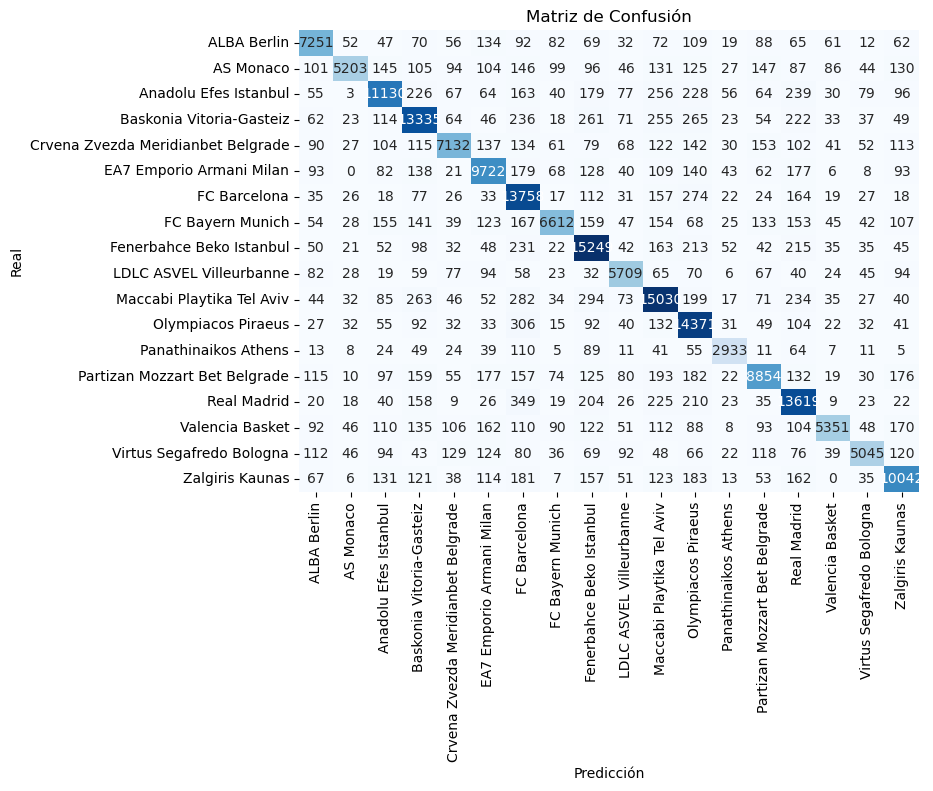

Precisión (Precision): 0.8707
Exhaustividad (Recall): 0.8689
F1 Score: 0.8684
Reporte de Clasificación:
                                    precision    recall  f1-score   support

                       ALBA Berlin       0.87      0.87      0.87      8373
                         AS Monaco       0.93      0.75      0.83      6916
             Anadolu Efes Istanbul       0.89      0.85      0.87     13052
          Baskonia Vitoria-Gasteiz       0.87      0.88      0.87     15168
Crvena Zvezda Meridianbet Belgrade       0.89      0.82      0.85      8702
          EA7 Emporio Armani Milan       0.87      0.88      0.87     11109
                      FC Barcelona       0.82      0.93      0.87     14838
                  FC Bayern Munich       0.90      0.80      0.85      8252
          Fenerbahce Beko Istanbul       0.87      0.92      0.89     16645
           LDLC ASVEL Villeurbanne       0.87      0.87      0.87      6592
         Maccabi Playtika Tel Aviv       0.86      0.89    

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Precisión (Precision) por clase
precision = precision_score(y_test, y_pred, average='weighted')  # Puedes usar 'micro', 'macro' o 'weighted'
print(f'Precisión (Precision): {precision:.4f}')

# Exhaustividad (Recall) por clase
recall = recall_score(y_test, y_pred, average='weighted')  # Puedes usar 'micro', 'macro' o 'weighted'
print(f'Exhaustividad (Recall): {recall:.4f}')

# F1 Score por clase
f1 = f1_score(y_test, y_pred, average='weighted')  # Puedes usar 'micro', 'macro' o 'weighted'
print(f'F1 Score: {f1:.4f}')

# Reporte completo de las métricas
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))



In [18]:
data_enriquecido_sinwinner = data_enriquecido.drop('winner', axis=1)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Suponiendo que 'data_enriquecido' ya está cargado y tiene las columnas necesarias

# Separar características (X) y etiqueta (y)
X = data_enriquecido.drop('winner_y', axis=1)  # Eliminar la columna de la etiqueta
y = data_enriquecido['winner_y']

# Codificar variables categóricas
label_encoder = LabelEncoder()

# Codificar las columnas categóricas, como 'team'
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Codificar la etiqueta 'winner_y'
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Entrenar el modelo Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

# Calcular precisión, recall y otras métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Precisión (Precision): {precision:.4f}')
print(f'Exhaustividad (Recall): {recall:.4f}')

# Predicción del equipo ganador en los nuevos datos (sin 'winner_y')
if 'winner_y' in X.columns:
    X = X.drop('winner_y', axis=1)  # Eliminar la columna 'winner_y'

# Realizar predicciones con el modelo entrenado
predicted_winner = model.predict(X_test[:1])  # Predecir con un solo ejemplo

# Decodificar el valor predicho para obtener el nombre del equipo
predicted_team = label_encoder.inverse_transform(predicted_winner)

# Imprimir el equipo ganador predicho
print(f'El equipo ganador predicho es: {predicted_team[0]}')



Precisión del modelo: 1.0000
Precisión (Precision): 1.0000
Exhaustividad (Recall): 1.0000
El equipo ganador predicho es: Fenerbahce Beko Istanbul


In [30]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Suponiendo que 'data_enriquecido' ya está cargado y tiene las columnas necesarias

# Separar características (X) y etiqueta (y)
X = data_enriquecido.drop('winner_y', axis=1)  # Eliminar la columna de la etiqueta
y = data_enriquecido['winner_y']

# Codificar variables categóricas
label_encoder = LabelEncoder()

# Codificar las columnas categóricas, como 'team'
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Codificar la etiqueta 'winner_y'
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Entrenar el modelo Random Forest
model_por = RandomForestClassifier()
model_por.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

# Calcular precisión, recall y otras métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Precisión (Precision): {precision:.4f}')
print(f'Exhaustividad (Recall): {recall:.4f}')

# Obtener las probabilidades de que un equipo gane (1) o pierda (0)
team_data = X_test[:1]  # Tomar un ejemplo para predecir
probabilities = model.predict_proba(team_data)

# Decodificar la etiqueta del equipo para obtener su nombre (si fue codificado previamente)
predicted_winner = model.predict(team_data)
predicted_team = label_encoder.inverse_transform(predicted_winner)

# Imprimir el nombre del equipo y las probabilidades en porcentaje
probabilidad_ganar = probabilities[0][1] * 100  # Probabilidad de ganar en porcentaje
probabilidad_perder = probabilities[0][0] * 100  # Probabilidad de perder en porcentaje

print(f'El equipo ganador predicho es: {predicted_team[0]}')
print(f'Probabilidad de ganar: {probabilidad_ganar:.2f}%')  # Probabilidad de ganar
print(f'Probabilidad de perder: {probabilidad_perder:.2f}%')  # Probabilidad de perder



Precisión del modelo: 1.0000
Precisión (Precision): 1.0000
Exhaustividad (Recall): 1.0000
El equipo ganador predicho es: Fenerbahce Beko Istanbul
Probabilidad de ganar: 0.00%
Probabilidad de perder: 0.00%
